# Hands-on session 3: Elephant (Solution)

These exercises build on concepts introduced in Tutorial 3

In this exercise, we will use two methods available in the Elephant library, namely the Unitary Event analysis to identify significant spike synchrony in a pair of spiketrains across all correct trials and SPADE method to find recurring patterns in the spike data of trial 1.


## Imports and Preparation

In [1]:
#!pip install git+https://github.com/INM-6/viziphant
#!pip install nixio

In [2]:
import quantities as pq
import neo.utils
import elephant
import viziphant

## Data loading


1. Load the data `reach_to_grasp_material/i140703-001.nix` file using the `neo.io.NixIO` into a neo Block.

In [3]:
with neo.io.NixIO('reach_to_grasp_material/i140703-001.nix', 'ro') as io:
    block = io.read_block()
segment = block.segments[0]

## Data preparation for Unitary Event (UE) analysis

2. At this step, extract the start events of all trial types that are correct. We will cut data from the trial start `TS-ON` to `2105*pq.ms`. Then, in the call to `neo.utils.add_epoch()`, supply these as correct parameters (Hint: call `neo.utils.add_epoch?` to view function documentation). The result should be an `Epoch` from `TS-ON` to 2105 ms *after* `TS-ON`.

In [4]:
start_events_all_trial_types = neo.utils.get_events(
    segment,
    trial_event_labels='TS-ON',
    performance_in_trial_str='correct_trial')

In [5]:
pre = 0 * pq.ms
post = 2105 * pq.ms

ue_epoch = neo.utils.add_epoch(
    segment,
    event1=start_events_all_trial_types[0], event2=None,
    pre=pre, post=post,
    attach_result=False,
    name='analysis_epochs')

3. Now you will need to find the best spiketrains to use for the UE analysis. These should: 
- be `'sua'`, 
- not be classified as `'noise'`,
- have a high signal-to-noise ratio (e.g. above 10)
- have a high spike count (e.g. above 10000)
- not be captured by electrodes rejected due to low, intermediate or high frequency components.

Create a new segement that contains the list of selected spiketrains that match these criteria. 

Hint: You may want to look into `segment.spiketrain[0].annotations` and list comprehensions to take the best spiketrains from all the spiketrains present in the segment.

In [6]:
# Select only SUA spike trains with spikes and certain quality criteria
ue_segment = neo.Segment()
ue_segment.spiketrains = [spiketrain for spiketrain in segment.spiketrains if
                                   spiketrain.annotations['sua'] and
                                   not spiketrain.annotations['electrode_reject_HFC'] and
                                   not spiketrain.annotations['electrode_reject_IFC'] and
                                   not spiketrain.annotations['electrode_reject_LFC'] and
                                   not spiketrain.annotations['noise'] and
                                   spiketrain.annotations['SNR'] > 10 and
                                   spiketrain.annotations['spike_count'] > 10000]

4. Print the number of spiketrains you have found. You will need a pair of spiketrains for the UE analysis.

In [7]:
print(f"The number of left over clean spike trains after filtering is {len(ue_segment.spiketrains)}")

The number of left over clean spike trains after filtering is 2


5. Now that we have isolated the good spiketrains, cut the segment according to the defined epoch using `neo.utils.cut_segment_by_epoch()`. From the result, prepare the input for the unitary event analysis, which is a list, where the `n`-th element is a list of spiketrains for the `n`-th trial, or, in other words, where the `n`-th element is the `spiketrains` attribute of the `n`-th segment.  

In [8]:
# Create the new block
ue_trials = neo.Block()

# Cut the recording segment into the trials, as defined by the epochs
ue_trials.segments = neo.utils.cut_segment_by_epoch(ue_segment, ue_epoch, reset_time=True)

sts_for_uea = [x.spiketrains for x in ue_trials.segments]

## UE analysis

The Unitary Event (UE) analysis method is very useful in detecting spiking coincidences between a two or several spike trains recorded simulaneously and determining their significance (Grün et al 2002a, Grün et al 2002b, Grün et al 2010). We are going to apply this method to look at a pair of spike trains from the Reach2Grasp dataset you have been exploring previously. The aim is to look for correlated spiking activity in the clean spike trains during all correct trials of all trial types.

The dataset should be a list of trials, containing a list of spike trains, which, in this case, is going to contain only two spike train objects.

You may want to consider the following parameters for the Unitary Event analysis:
* `bin_size`: The size of bins for discretizing spike trains.
* `win_size`: The size of the window of analysis
* `win_step`: The size of the window step.
* `pattern`: The binary pattern, indicating which neurons should participate in the pattern. E.g. [1, 1] for two out of two neurons, [1, 1, 0] for the first two out of three neurons.
* `pattern_hash`: The list of interesting patterns in hash values. Generated from `pattern` using `hash_from_pattern` function.
* `significance_level`: The level of significance for p-value evaluation. 
* `method` Determines the approach for unitary event computation.
    * `analytic_TrialByTrial`: calculates the expectancy analytically on each trial, then sums over all of them
    * `analytic_TrialAverage`: calculates the expectancy analytically by averaging over trials
    * `surrogate_TrialByTrial`: calculates the distribution of expected coincidences by spike time randomization in each different trial, then sums over all of them
    
6. Run UE analysis using `elephant.unitary_event_analysis.jointJ_window_analysis()` and pass the result together with additional parameters to the viziphant function provided below. You may want to use a `plot_params` dictionary to add unit names and `TS-ON` trigger marker to the plot.

In [9]:
### Unitary events
winsize = 100 * pq.ms
binsize = 5 * pq.ms  
winstep = 5 * pq.ms 
significance_level = 0.05
N = 2
pattern = [1, 1]
pattern_hash = [elephant.unitary_event_analysis.hash_from_pattern(pattern, 2)]
method = 'analytic_TrialByTrial'

plot_params = {
    'events': {'TS-ON': [0 * pq.ms]},
    'unit_real_ids': [sts_for_uea[0][0].name[-5:], sts_for_uea[0][1].name[-5:]],
    'hspace': 0.6,
    'figsize': (10, 12),
    'fsize': 12,
    'ms': 5,
    'lw': 1
}

In [10]:
uriana = elephant.unitary_event_analysis.jointJ_window_analysis(sts_for_uea, bin_size=binsize, winsize=winsize, winstep=winstep,
                                   pattern_hash=pattern_hash, method=method)


/home/denker/miniconda3/envs/school_lyon/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/denker/miniconda3/envs/school_lyon/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


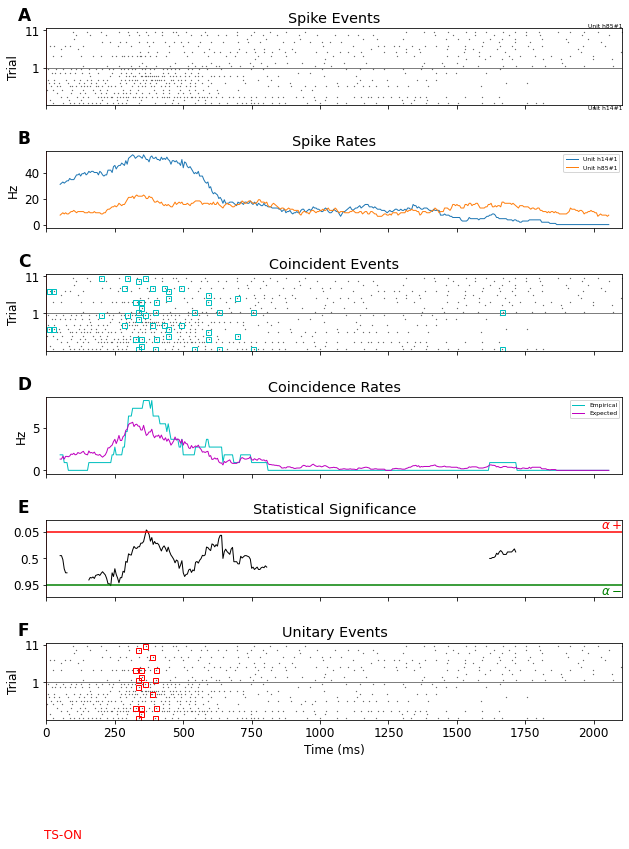

In [11]:
fig = viziphant.unitary_event_analysis.plot_ue(sts_for_uea, uriana, significance_level, **plot_params)

Optional: Explore the parameters of the functions. Can you add the missing triggers between `TS-ON` and 2105 ms after `TS-ON` to the generated plot?

## Data preparation for SPADE

7. In close analogy to the beginning of tutorial 3 and what we have done above, prepare a Neo `Block`, containing one `Segment` of SGHF data of the first correct trial. Name this `Segement` by the variable `trial`, as in tutorial 3.  In contrast to the lecture and the UE analysis above, we will cut data from the trial start `TS-ON` to reward administration indicated by event `RW-ON`. To this end, first find also the `RW-ON` events similar to how we found `TS-ON` in tutorial 3. Then, in the call to `neo.utils.add_epoch()`, supply these as a second event `event2=` *instead* of giving `t_pre=0` and `t_post=2*pq.s`. This will cut from event 1 to event 2, instead of a fixed amount of 2 s around event 1 (as in tutorial 3 or the UE exercise above).

In [12]:
start_events = neo.utils.get_events(
    segment,
    trial_event_labels='TS-ON',
    belongs_to_trialtype='SGHF',
    performance_in_trial_str='correct_trial')

## Additinally, get RW-ON events
stop_events = neo.utils.get_events(
    segment,
    trial_event_labels='RW-ON',
    belongs_to_trialtype='SGHF',
    performance_in_trial_str='correct_trial')

In [13]:
# Create epochs between the events
trial_epochs = neo.utils.add_epoch(
    segment,
    event1=start_events[0],     # The function returns a list, we need to retrieve the object which is the first (digital port events)
    event2=stop_events[0],
    array_annotations=start_events[0].array_annotations)

In [14]:
# Create the new block
spade_trials = neo.Block()

# Cut the recording segment into the trials, as defined by the epochs
spade_trials.segments = neo.utils.cut_segment_by_epoch(segment, trial_epochs, reset_time=True)

In [15]:
# Select first segment as the trial for analysis
spade_trial = spade_trials.segments[0]

## SPADE analysis

Note that patterns in this data are not easily to spot by eye in the rasterplot we developed in tutorial 3.
We use SPADE (Torre et al., 2013; Stella et al. 2019) as a technique that does that for us by finding all patterns and checking for each pattern if it occurs more often than expected given its complexity (number of neurons participating) and frequency. Before going directly to the analysis we briefly explain SPADE's most important parameters:

- `binsize`: temporal precision of the method. The smaller the binsize is, the more precisely we expect each single pattern to repeat. This raises an important question: which is the temporal precision that are you interested in? It depends on the scientific question! We often use 5ms, based on a number of studies on the minimal neuronal temporal precision.
- `winlen`: window length, or maximal length allowed to each pattern, expressed in bin units. SPADE will detect patterns with a temporal duration up to the window length. If winlen=1, then only synchronous patterns are detected. Are you interested in synchronous higher-order correlations? Are you interested in patterns with delays? Note: the higher the winlen parameter is, the more expensive (memory and time) the pattern search is!
- `min_spikes` and `min_neu`: minimum number of spikes and minimum number of neurons allowed in a pattern. These parameters are important, too. Do you want to look for pattern with a particular size? Are you interested in patterns with multiple spikes coming from the same neuron?
- `n_surr`: number of surrogates used for the statistical testing. If the number of surrogates is set to zero, then all patterns are retrieved by SPADE without further testing. If, instead, the number of surrogates is different from zero (typically we suggest to use a large number - the more the better!) then only the significant patterns are retrieved from the analysis. For simplicity, we will set this parameter to `n_surr=0` in the following.

Next steps:
8. As in tutorial 3, select only good quality neurons using the annotations (i.e., SUA units, more than 10000 spikes,...)

In [16]:
# Select only SUA spike trains with spikes and certain quality criteria
spiketrains = [spiketrain for spiketrain in spade_trial.spiketrains if
                                   spiketrain.annotations['sua'] and
                                   not spiketrain.annotations['electrode_reject_HFC'] and
                                   not spiketrain.annotations['electrode_reject_IFC'] and
                                   not spiketrain.annotations['electrode_reject_LFC'] and
                                   not spiketrain.annotations['noise'] and
                                   spiketrain.annotations['spike_count'] > 10000]

9. Run the SPADE analysis by executing the code given below:

In [17]:
# Fix parameters for SPADE
binsize = 5 * pq.ms
winlen = 1
min_spikes = 2
n_surr = 0
min_neu = 2
min_occ = 2

In [18]:
result = elephant.spade.spade(
        spiketrains=spiketrains, binsize=binsize, winlen=winlen,
        min_spikes=min_spikes, n_surr=n_surr, min_neu=min_neu, min_occ=min_occ)
patterns = result['patterns']

/home/denker/miniconda3/envs/school_lyon/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Time for data mining: 0.316211462020874


10. Let's look at the output in `patterns`. How many patterns were found? How does one pattern look as an output?

In [19]:
# Print the length of the list of patterns found, and the first pattern as an example
len(patterns), patterns[0]

(5346,
 {'itemset': (22, 50),
  'windows_ids': (127, 192),
  'neurons': [22, 50],
  'lags': array([0.]) * ms,
  'times': array([635., 960.]) * ms,
  'signature': (2, 2),
  'pvalue': -1})

11. Display five detected patterns in the data and their statistics by executing the Viziphant function calls given below

<AxesSubplot:xlabel='Time (s)', ylabel='Neuron'>

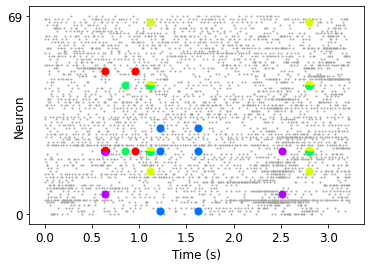

In [20]:
viziphant.patterns.plot_patterns(spiketrains, patterns[:5], circle_sizes=(1, 50, 70))


array([<AxesSubplot:xlabel='Neuronal participation in patterns', ylabel='Count'>,
       <AxesSubplot:xlabel='Pattern occurrences', ylabel='Count'>,
       <AxesSubplot:xlabel='Pattern size', ylabel='Count'>], dtype=object)

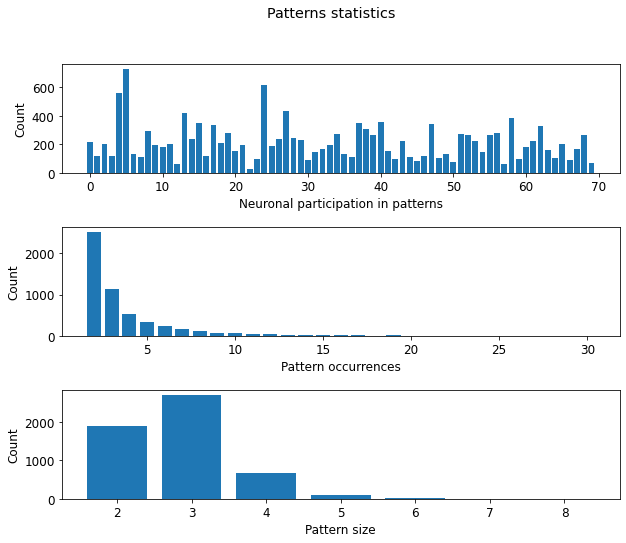

In [21]:
viziphant.patterns.plot_patterns_statistics_all(patterns)

# References
1. Grün et al (2002a) DOI: 10.1162/089976602753284455
2. Grün et al (2002b) DOI: 10.1162/089976602753284464
3. Grün et al (2010) DOI: 10.1007/978-1-4419-5675-0_10
4. Torre et al (2013) DOI: 10.3389/fncom.2013.00132
5. Stella et al (2019) DOI: 10.1016/j.biosystems.2019.104022